# VAE AUTOENCODER VARIATIONAL IMPLEMENTATION


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist


In [2]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and flatten the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


11490434/11490434 [==============================] - 1s 0us/step


In [3]:
# Network parameters
input_shape = (28, 28, 1)
batch_size = 128
latent_dim = 2  # Dimensionality of the latent space

# Encoder architecture
inputs = Input(shape=input_shape, name='encoder_input')
x = Flatten()(inputs)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder architecture
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(128, activation='relu')(latent_inputs)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(np.prod(input_shape), activation='sigmoid')(x)
outputs = Reshape(input_shape)(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# VAE Model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['encoder_input[0][0]']       
                                                                                                  
 dense (Dense)               (None, 512)                  401920    ['flatten[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 256)                  131328    ['dense[0][0]']               
                                                                                            

In [4]:
# VAE loss = reconstruction loss + KL divergence loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= 28 * 28

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


In [6]:
vae.fit(x_train, epochs=12, batch_size=batch_size, validation_data=(x_test, None))


Epoch 1/12
469/469 [==============================] - 16s 35ms/step - loss: 140.3910 - val_loss: 141.5753
Epoch 2/12
469/469 [==============================] - 17s 36ms/step - loss: 140.3632 - val_loss: 139.9926
Epoch 3/12
469/469 [==============================] - 19s 41ms/step - loss: 139.1481 - val_loss: 139.1282
Epoch 4/12
469/469 [==============================] - 16s 35ms/step - loss: 138.8920 - val_loss: 139.0231
Epoch 5/12
469/469 [==============================] - 18s 38ms/step - loss: 138.6880 - val_loss: 139.5341
Epoch 6/12
469/469 [==============================] - 17s 36ms/step - loss: 138.9585 - val_loss: 139.0856
Epoch 7/12
469/469 [==============================] - 17s 37ms/step - loss: 138.6741 - val_loss: 138.2772
Epoch 8/12
469/469 [==============================] - 16s 35ms/step - loss: 137.7808 - val_loss: 138.3151
Epoch 9/12
469/469 [==============================] - 17s 35ms/step - loss: 137.7625 - val_loss: 137.3714
Epoch 10/12
469/469 [=========================

79/79 [==============================] - 1s 11ms/step


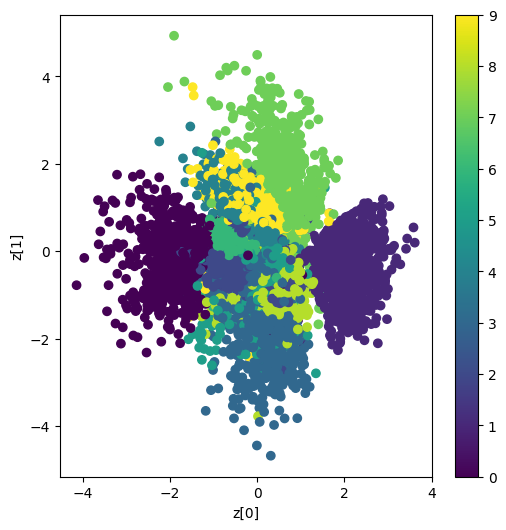

1/1 [==============================] - 0s 20ms/step


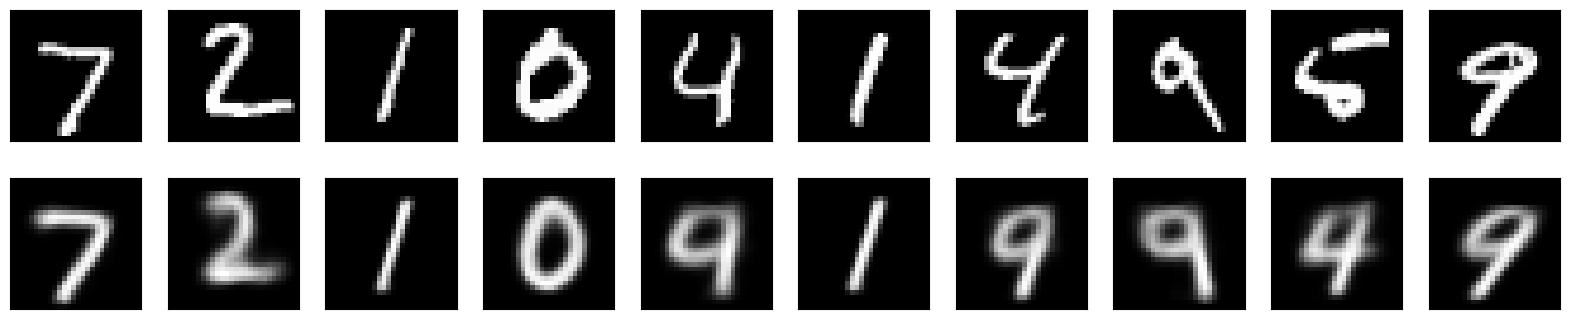

In [8]:
import matplotlib.pyplot as plt

# Function to display original and reconstructed images side by side
def plot_results(models, data, batch_size=128, model_name="vae_mnist"):
    encoder, decoder = models
    x_test, y_test = data
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)

    # Display a 2D plot of the digit classes in the latent space
    plt.figure(figsize=(6, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # Display original and reconstructed images
    n = 10  # number of digits to display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        reconstructed_img = decoder.predict(np.expand_dims(z_mean[i], axis=0))
        plt.imshow(reconstructed_img.reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Load MNIST data with labels
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype('float32') / 255.0
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Plot results: original vs reconstructed
plot_results((encoder, decoder), (x_test, y_test))
